# Mutation-Based Fuzzing

Most [randomly generated inputs](Fuzzer.ipynb) are 
syntactically _invalid_ 
quickly rejected by the processing program. 

To exercise functionality beyond input processing, we must increase chances to obtain valid inputs. 

One such way is *mutational fuzzing* – 
[[Introducing small changes to existing inputs that may still keep the input valid, yet exercise new behavior.]]

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from fuzzingbook.MutationFuzzer import <identifier>
```


`MutationFuzzer` class takes a list of _seed inputs_ which are then mutated:

```python
>>> seed_input = "http://www.google.com/search?q=fuzzing"
>>> mutation_fuzzer = MutationFuzzer(seed=[seed_input])
>>> [mutation_fuzzer.fuzz() for i in range(10)]
['http://www.google.com/search?q=fuzzing',
 'http://www.g=oNogl.om/search?q=fuzzing/',
 'RttpX://w)ww.goo(gle.comq/sarc(q=fuzzng',
 'hdt8p://"wWw.goole.com/seDarb`*?q=fuzzing',
 'httop://www.CooglGe.om/s$arch?q=fuzzingY',
 'http://wwlw.google.c"om/secrch?yq=fuzzin',
 'hup://www.google.comC/search?q=fuzzing',
 'http://w7w.google.com/search?q=ufuzgzing',
 'http://www,google.com/sear4ch?.q=fuzzing',
 'http://w&ww.google.cKom/search7q=fuzzing']
```
The `MutationCoverageFuzzer` maintains a _population_ of inputs, which are then evolved in order to maximize coverage.

```python
>>> mutation_fuzzer = MutationCoverageFuzzer(seed=[seed_input])
>>> mutation_fuzzer.runs(http_runner, trials=10000)
>>> mutation_fuzzer.population[:5]
['http://www.google.com/search?q=fuzzing',
 'htTp://www.googld.cqom/searchq=fuzzIng',
 'htTp://www.gloogld.qom/|searchq=fuzzng',
 'htTp://www.googld.cqomo0searchq=fuzzIng',
 'htTp://www*goegld.cqoe/sa7#hq=fuzIng']
```


## Fuzzing with Mutations

On November 2013, the first version of [American Fuzzy Lop](http://lcamtuf.coredump.cx/afl/) (AFL) was released. Since then, AFL has become one of the most successful fuzzing tools and comes in many flavours, e.g., [AFLFast](https://github.com/mboehme/aflfast), [AFLGo](https://github.com/aflgo/aflgo), and [AFLSmart](https://github.com/aflsmart/aflsmart) (which are discussed in this book). AFL has made fuzzing a popular choice for automated vulnerability detection. It was the first to demonstrate that vulnerabilities can be detected automatically at a large scale in many security-critical, real-world applications.

![American Fuzzy Lop Command Line User Interface](PICS/afl_screen.png)
<center><b>Figure 1.</b> American Fuzzy Lop Command Line User Interface</center>

In this chapter, we are going to introduce the basics of mutational fuzz testing; the next chapter will then further show how to direct fuzzing towards specific code goals.

## Fuzzing a URL Parser

Many programs expect their inputs to come in a very specific format before they would actually process them.  As an example, think of a program that accepts a URL (a Web address).  The URL has to be in a valid format (i.e., the URL format) such that the program can deal with it.  When fuzzing with random inputs, what are our chances to actually produce a valid URL?

To get deeper into the problem, let us explore what URLs are made of.  A URL consists of a number of elements:

    scheme://netloc/path?query#fragment
    
where

* `scheme` is the protocol to be used, including `http`, `https`, `ftp`, `file`...
* `netloc` is the name of the host to connect to, such as `www.google.com`
* `path` is the path on that very host, such as `search`
* `query` is a list of key/value pairs, such as `q=fuzzing`
* `fragment` is a marker for a location in the retrieved document, such as `#result`

In Python, we can use the `urlparse()` function to parse and decompose a URL into its parts.

In [1]:
from fuzzingbook import fuzzingbook_utils

In [2]:
try:
    from urlparse import urlparse      # Python 2
except ImportError:
    from urllib.parse import urlparse  # Python 3

urlparse("http://www.google.com/search?q=fuzzing")

ParseResult(scheme='http', netloc='www.google.com', path='/search', params='', query='q=fuzzing', fragment='')

We see how the result encodes the individual parts of the URL in different attributes.

A program that takes a URL as input.  
Checks the passed URL for validity.  
If the URL is valid, it returns True; otherwise, it raises an exception.

In [3]:
def http_program(url):
    supported_schemes = ["http", "https"]
    result = urlparse(url)
    if result.scheme not in supported_schemes:
        raise ValueError("Scheme must be one of " + repr(supported_schemes))
    if result.netloc == '':
        raise ValueError("Host must be non-empty")

    # Do something with the URL
    return True #True if URL can be parsed ie. Valid

Let us now go and fuzz `http_program()`.  To fuzz, we use the full range of printable ASCII characters, such that `:`, `/`, and lowercase letters are included.

In [4]:
from fuzzingbook.Fuzzer import fuzzer
# from Fuzzer import fuzzer

In [5]:
fuzzer(char_start=32, char_range=96)

'"N&+slk%h\x7fyp5o\'@[3(rW*M5W]tMFPU4\\P@tz%[X?uo\\1?b4T;1bDeYtHx #UJ5w}pMmPodJM,_'

Let's try to fuzz with 1000 random inputs and see whether we have some success.

In [26]:
for i in range(1000):
    try:
        url = fuzzer() #fuzzzer generates the random url
        result = http_program(url) #send url to code for url parsing
        print("Success!")
    except ValueError:
#         print("Failure")
        pass

What are the chances of actually getting a valid URL?  We need our string to start with `"http://"` or `"https://"`.  Let's take the `"http://"` case first.  These are seven very specific characters we need to start with.  The chance of producing these seven characters randomly (with a character range of 96 different characters) is $1 : 96^7$, or 75144747810816. The odds of producing a "https://" prefix are even worse, at  1:968 :

which gives us a total chance of likelihood = 1 / (96 ** 7) + 1 / (96 ** 8)
=1.344627131107667e-14

In [7]:
likelihood = 1 / (96 ** 7) + 1 / (96 ** 8)

And this is the number of runs (on average) we'd need to produce a valid URL scheme: 1/likelihood=74370059689055.02

Let's measure how long one run of `http_program()` takes:

In [8]:
from fuzzingbook.MutationFuzzer import Timer
#not from Timer import Timer
trials = 1000
with Timer() as t:
    for i in range(trials):
        try:
            url = fuzzer()
            result = http_program(url)
            print("Success!")
        except ValueError:
            pass

duration_per_run_in_seconds = t.elapsed_time() / trials
duration_per_run_in_seconds

0.00010711776700000009

That's pretty fast, isn't it?  Unfortunately, we have a lot of runs to cover.

In [9]:
seconds_until_success = duration_per_run_in_seconds * (1 / likelihood)
seconds_until_success

7966354725.548294

which translates into

In [27]:
hours_until_success = seconds_until_success / 3600
days_until_success = hours_until_success / 24
years_until_success = days_until_success / 365.25
print(years_until_success,"years")

252.43854810087882 years


Even if we parallelize things a lot, we're still in for months to years of waiting.  And that's for getting _one_ successful run that will get deeper into `http_program()`.

What basic fuzzing will do well is to test `urlparse()`, and if there is an error in this parsing function, it has good chances of uncovering it.  But as long as we cannot produce a valid input, we are out of luck in reaching any deeper functionality.

## Mutating Inputs

The alternative to generating random strings from scratch is to start with a given _valid_ input, and then to subsequently _mutate_ it.

A _mutation_ in this context is a simple string manipulation - say, inserting a (random) character, deleting a character, or flipping a bit in a character representation.  

This is called *mutational fuzzing* – in contrast to the _generational fuzzing_ techniques discussed earlier.

Here are some mutations to get you started:

In [11]:
#Delete random characters from a given string
import random
def delete_random_character(s):
    """Returns s with a random character deleted"""
    if s == "":
        return s

    pos = random.randint(0, len(s) - 1) #position to insert string
    # print("Deleting", repr(s[pos]), "at", pos)
    return s[:pos] + s[pos + 1:]

In [12]:
seed_input = "A quick brown fox"
for i in range(10):
    x = delete_random_character(seed_input)
    print(repr(x)) #repr() gets string representation of the pobject

'A uick brown fox'
'A quic brown fox'
'A quick brown fo'
'A quic brown fox'
'A quick bown fox'
'A quick bown fox'
'A quick brown fx'
'A quick brown ox'
'A quick brow fox'
'A quic brown fox'


In [13]:
#Insert random char(s) in a string
def insert_random_character(s):
    """Returns s with a random character inserted"""
    pos = random.randint(0, len(s))
    random_character = chr(random.randrange(32, 127))
    # print("Inserting", repr(random_character), "at", pos)
    return s[:pos] + random_character + s[pos:]

In [14]:
for i in range(10):
    print(repr(insert_random_character(seed_input)))

'A quick brvown fox'
'A quwick brown fox'
'A qBuick brown fox'
'A quick broSwn fox'
'A quick brown fvox'
'A quick brown 3fox'
'A quick brNown fox'
'A quick brow4n fox'
'A quick brown fox8'
'A equick brown fox'


In [15]:
def flip_random_character(s):
    """Returns s with a random bit flipped in a random position"""
    if s == "":
        return s

    pos = random.randint(0, len(s) - 1)
    c = s[pos] #put char in c 
    bit = 1 << random.randint(0, 6) #rand bit to flip in hex code
    new_c = chr(ord(c) ^ bit) #rand char formed from hex, pur in new_c
#     print("Flipping", bit, "in", repr(c) + ", giving", repr(new_c))
    return s[:pos] + new_c + s[pos + 1:]


In [16]:
for i in range(10):
    print(repr(flip_random_character(seed_input)))

'A quick bRown fox'
'A quici brown fox'
'A"quick brown fox'
'A quick brown$fox'
'A quick bpown fox'
'A quick brown!fox'
'A 1uick brown fox'
'@ quick brown fox'
'A quic+ brown fox'
'A quick bsown fox'


Let us now create a random mutator that randomly chooses which mutation to apply:

In [17]:
def mutate(s):
    """Return s with a random mutation applied"""
    mutators = [
        delete_random_character,
        insert_random_character,
        flip_random_character
    ]
    mutator = random.choice(mutators)
#     print(mutator)
    return mutator(s)

In [18]:
for i in range(10):
    print(repr(mutate("A quick brown fox")))

'A qzuick brown fox'
' quick brown fox'
'A quick Brown fox'
'A qMuick brown fox'
'A qu_ick brown fox'
'A quick bXrown fox'
'A quick brown fx'
'A quick!brown fox'
'A! quick brown fox'
'A quick brownfox'


The idea is now that _if_ we have some valid input(s) to begin with, we may create more input candidates by applying one of the above mutations.  To see how this works, let's get back to URLs.

## Mutating URLs

Let us now get back to our URL parsing problem.  Let us create a function `is_valid_url()` that checks whether `http_program()` accepts the input.

In [19]:
#First, create a valid input
def is_valid_url(url):
    try:
        result = http_program(url)
        return True
    except ValueError:
        return False

In [20]:
#Verify using Assert, if correct no output, it incorrect returns error
assert is_valid_url("http://www.google.com/search?q=fuzzing")
assert not is_valid_url("xyzzy")

Let us now apply the `mutate()` function on a given URL and see how many valid inputs we obtain.

In [29]:
#Check after how many trails in mutate(), we get valid ip
seed_input = "http://www.google.com/search?q=fuzzing"
valid_inputs = set()
trials = 20 #N loops

for i in range(trials):
    inp = mutate(seed_input)
    if is_valid_url(inp):
        print("valid", inp)
        valid_inputs.add(inp)
    else:
        print("invalid", inp)

invalid http:*//www.google.com/search?q=fuzzing
valid http://www.google.com/search?fq=fuzzing
valid http://www.google.com/search?q=fuzzin
invalid ttp://www.google.com/search?q=fuzzing
valid http://www.google.com/search?q=f]uzzing
invalid http//www.google.com/search?q=fuzzing
valid http://www.gnogle.com/search?q=fuzzing
valid http://ww.google.com/search?q=fuzzing
valid http://www.gogle.com/search?q=fuzzing
valid http://www.googl.com/search?q=fuzzing
valid http://www.google.com/search?1=fuzzing
valid http://www.google.coi/search?q=fuzzing
valid http://www.google.com/search?q=fuzzin
valid http://www.googl.com/search?q=fuzzing
invalid http~://www.google.com/search?q=fuzzing
valid http://wwwI.google.com/search?q=fuzzing
valid http://ww.google.com/search?q=fuzzing
valid http://www.google.com/3earch?q=fuzzing
valid http://www.goog|e.com/search?q=fuzzing
valid http://www.google.c^om/search?q=fuzzing


We can now observe that by _mutating_ the original input, we get a high proportion of valid inputs:

In [22]:
#proportion of valid ip as per trails
len(valid_inputs) / trials  

0.8

What are the odds of also producing a `https:` prefix by mutating a `http:` sample seed input?  We have to insert ($1 : 3$) the right character `'s'` ($1 : 96$) into the correct position ($1 : l$), where $l$ is the length of our seed input.  This means that on average, we need this many runs:

In [23]:
trials = 3 * 96 * len(seed_input)
trials

10944

We can actually afford this.  Let's try:

In [30]:
from fuzzingbook.MutationFuzzer import Timer

In [31]:
trials = 0
with Timer() as t:
    while True:
        trials += 1
        inp = mutate(seed_input)
        if inp.startswith("https://"):
            print(
                "Success after",
                trials,
                "trials in",
                t.elapsed_time(),
                "seconds")
            break

Success after 26545 trials in 0.1614408849999336 seconds


Of course, if we wanted to get, say, an `"ftp://"` prefix, we would need more mutations and more runs – most important, though, we would need to apply _multiple_ mutations.

## Multiple Mutations

So far, we have only applied one single mutation on a sample string.  However, we can also apply _multiple_ mutations, further changing it.  What happens, for instance, if we apply, say, 20 mutations on our sample string?

In [32]:
seed_input = "http://www.google.com/search?q=fuzzing"
mutations = 50

In [33]:
inp = seed_input
for i in range(mutations):
    if i % 5 == 0:
        print(i, "mutations:", repr(inp))
    inp = mutate(inp)

0 mutations: 'http://www.google.com/search?q=fuzzing'
5 mutations: 'ittp://wW7w.google.com/search?q=fzzng'
10 mutations: 'ittp:/wW7Iw.gomgle.com/searc=?q=fzzng'
15 mutations: 'i>utp:/wW7Iw;.gomglRe.com/searc=?q=f~zng'
20 mutations: 'i>utp:/wW7Iw;.omgmRe.&com/sZearc=?q=~zng'
25 mutations: 'm>utp:/wW7Iw;.omgRse.&comsZearc=?q=zng'
30 mutations: 'm>utp:/wW7IGw;.omgRse,&cosZearc=R?q=zn'
35 mutations: 'm>utp:/wW7IGw{.omgRse,cosZears=R\x1fq=z'
40 mutations: 'm>utYr:|wW7IGw{.OmgRse,cosZears=R\x1fq=z'
45 mutations: 'mtYr:|wW7IGw{.OmgRse,osZ5ers=R\x1fq=z'


As you see, the original seed input is hardly recognizable anymore.  By mutating the input again and again, we get a higher variety in the input.

To implement such multiple mutations in a single package, let us introduce a `MutationFuzzer` class.  
It takes a seed (a list of strings) as well as a minimum and a maximum number of mutations.  

In [34]:
from fuzzingbook.MutationFuzzer import Fuzzer

In [35]:
class MutationFuzzer(Fuzzer):
    def __init__(self, seed, min_mutations=2, max_mutations=10):
        self.seed = seed
        self.min_mutations = min_mutations
        self.max_mutations = max_mutations
        self.reset()

    def reset(self):
        self.population = self.seed
        self.seed_index = 0

In the following, let us develop `MutationFuzzer` further by adding more methods to it.  
The Python language requires us to define an entire class with all methods as a single, continuous unit; 
however, we would like to introduce one method after another.  
To avoid this problem, we use a special hack: 
Whenever we want to introduce a new method to some class `C`, we use the construct

```python
class C(C):
    def new_method(self, args):
        pass
```

This seems to define `C` as a subclass of itself, which would make no sense – but actually, it introduces a new `C` class as a subclass of the _old_ `C` class, and then shadowing the old `C` definition.  
What this gets us is a `C` class with `new_method()` as a method, which is just what we want.  
(`C` objects defined earlier will retain the earlier `C` definition, though, and thus must be rebuilt.)

Using this hack, we can now add a `mutate()` method that actually invokes the above `mutate()` function.  Having `mutate()` as a method is useful when we want to extend a `MutationFuzzer` later.

In [36]:
class MutationFuzzer(MutationFuzzer):
    def mutate(self, inp):  #define new method
        return mutate(inp)  #call mutate()

Let's get back to our strategy, maximizing _diversity in coverage_ in our population.  First, let us create a method `create_candidate()`, which randomly picks some input from our current population (`self.population`), and then applies between `min_mutations` and `max_mutations` mutation steps, returning the final result:

In [37]:
class MutationFuzzer(MutationFuzzer):
    def create_candidate(self):
        candidate = random.choice(self.population)
        trials = random.randint(self.min_mutations, self.max_mutations)
        for i in range(trials):
            candidate = self.mutate(candidate)
        return candidate

The `fuzz()` method is set to first pick the seeds; when these are gone, we mutate:

In [39]:
#fuzz() is created to pick a seed from population of mutated seeds
class MutationFuzzer(MutationFuzzer):
    def fuzz(self):
        if self.seed_index < len(self.seed):
            # Still seeding
            self.inp = self.seed[self.seed_index]
            self.seed_index += 1
        else:
            # Mutating
            self.inp = self.create_candidate()
        return self.inp

In [40]:
seed_input = "http://www.google.com/search?q=fuzzing"
mutation_fuzzer = MutationFuzzer(seed=[seed_input])
mutation_fuzzer.fuzz()

'http://www.google.com/search?q=fuzzing'

In [41]:
mutation_fuzzer.fuzz() #picks new seed from population

'httOp:/wwgoogle.vco}/searc,)h?q=fuzzing'

In [42]:
mutation_fuzzer.fuzz() #picks another seed from population

'http://www.googlea.bom/seirch?q=fuzzing'

With every new invocation of `fuzz()`, we get another variant with multiple mutations applied.  The higher variety in inputs, though, increases the risk of having an invalid input.  The key to success lies in the idea of _guiding_ these mutations – that is, _keeping those that are especially valuable._

## Guiding by Coverage

To cover as much functionality as possible, one can rely on either _specified_ or _implemented_ functionality, as discussed in the ["Coverage"](Coverage.ipynb) chapter.  

For now, we will not assume that there is a specification of program behavior (although it _definitely_ would be good to have one!).  
We _will_ assume, though, that the program to be tested exists – and that we can leverage its structure to guide test generation.

Since testing always executes the program at hand, one can always gather information about its execution – the least is the information needed to decide whether a test passes or fails. 
Since coverage is frequently measured as well to determine test quality, let us also assume we can retrieve coverage of a test run.  
The question is then: _How can we leverage coverage to guide test generation?_

One particularly successful idea is implemented in the popular fuzzer named [American fuzzy lop](http://lcamtuf.coredump.cx/afl/), or *AFL* for short.  Just like our examples above, AFL evolves test cases that have been successful – but for AFL, "success" means _finding a new path through the program execution_.  This way, AFL can keep on mutating inputs that so far have found new paths; and if an input finds another path, it will be retained as well.

Let us build such a strategy.  
We start with introducing a `Runner` class that captures the coverage for a given function.  
First, a `FunctionRunner` class:

In [43]:
from fuzzingbook.MutationFuzzer import Runner

In [44]:
#Class that runs a function for a given inp url, DOESNOT check coverage yet
class FunctionRunner(Runner):
    def __init__(self, function):
        """Initialize.  `function` is a function to be executed"""
        self.function = function

    def run_function(self, inp):
        return self.function(inp)

    def run(self, inp):
        try:
            result = self.run_function(inp)
            outcome = self.PASS
        except Exception:
            result = None
            outcome = self.FAIL

        return result, outcome

In [45]:
http_runner = FunctionRunner(http_program)
http_runner.run("https://foo.bar/")

(True, 'PASS')

We can now extend the `FunctionRunner` class such that it also measures coverage.  After invoking `run()`, the `coverage()` method returns the coverage achieved in the last run.

In [46]:
from fuzzingbook.MutationFuzzer import Coverage, population_coverage

In [47]:
#Extend the class created before to check coverage ie. add new method called coverage()
class FunctionCoverageRunner(FunctionRunner):
    def run_function(self, inp):   #------run function
        with Coverage() as cov:
            try:
                result = super().run_function(inp)
            except Exception as exc:
                self._coverage = cov.coverage()
                raise exc

        self._coverage = cov.coverage()
        return result

    def coverage(self):     #-------check coverage
        return self._coverage

In [48]:
http_runner = FunctionCoverageRunner(http_program)
http_runner.run("https://foo.bar/")

(True, 'PASS')

Here are the first five locations covered: 

In [49]:
print(list(http_runner.coverage())[:5])

[('urlsplit', 421), ('urlparse', 373), ('_coerce_args', 119), ('http_program', 4), ('urlsplit', 418)]


Now for the main class.  We maintain the population and a set of coverages already achieved (`coverages_seen`).  
The `fuzz()` helper function takes an input and runs the given `function()` on it.  
If its coverage is new (i.e. not in `coverages_seen`), the input is added to `population` and the coverage to `coverages_seen`.

In [50]:
class MutationCoverageFuzzer(MutationFuzzer):
    def reset(self):
        super().reset()
        self.coverages_seen = set()  #Define empty set for coverages_seen
        # Now empty; we fill this with seed in the first fuzz runs
        self.population = []

    def run(self, runner):
        """Run function(inp) while tracking coverage.
           If we reach new coverage, add inp to population and its coverage to population_coverage
        """
        result, outcome = super().run(runner)
        new_coverage = frozenset(runner.coverage())
        if outcome == Runner.PASS and new_coverage not in self.coverages_seen:
            # We have new coverage
            self.population.append(self.inp)
            self.coverages_seen.add(new_coverage)

        return result

Let us now put this to use:

In [51]:
seed_input = "http://www.google.com/search?q=fuzzing"
mutation_fuzzer = MutationCoverageFuzzer(seed=[seed_input])
mutation_fuzzer.runs(http_runner, trials=10000)
mutation_fuzzer.population

['http://www.google.com/search?q=fuzzing',
 'http://ww.googl.com/searh?q=fuzzing',
 'http://ww.googlcm/earh>q=f}zzing',
 'http://ww.googl.comsearhq=fezzing',
 'http://wW.7woog.#o-earhpn=fezzing',
 'http://wW.7woog.\x03-earhpn=fezzing',
 'http://wW.7wog.#o-earhpn=fez8zin',
 'httP://W^7woog.\x03-ecbhpn=agzzig',
 'http://w.googlc/e`2h>5q;=f}zzinHg',
 'http://wW.?wog.#o-earhpn=lfNez8zin',
 'httP://W^7w/oog.\x03-e0cbbhp.=agz\x13zig',
 'Http://wW.?wvog.4#o-earhn=lNez8xin',
 'Http://wW.=wvog.4h#o-ea2rhn=lNez8x)n',
 'Http://wW.=Swog.4h#n-ea2hn=lNezx)n',
 'Http://W.?wvo.4"g9-erhn=lNez8xin',
 'Http://w7W.?vog.#o-ea$rh=lNezrQ8xil',
 'htTp://w.molc/e`92h>5q;=&]zzi~vHg',
 'Http://(W.?w9vog.n4o-earhjO=lNez8xif',
 'http://w.googlc/(e`2h>5$q;=f}zzing',
 'httP://W<~7woog\x03-ec`p=agzig',
 'htTp://w.molc/e`92h&>5q;?&]zxi~vHg',
 'http://ww\x7f.go\x7fgle.coih/suarch\x1fq=fuzDing',
 'http://w.ooglc/(`2h>5$q;=f}:z#ing',
 'htTp://w/molc/le`\x192>5s;=&]Ezzi~v@g',
 "http://w.%ooglc/8`2h>5$q;=f}:Qj'i?ng",
 'htT

Success!  In our population, _each and every input_ now is valid and has a different coverage, coming from various combinations of schemes, paths, queries, and fragments.

In [52]:
all_coverage, cumulative_coverage = population_coverage(mutation_fuzzer.population, http_program)

In [53]:
import matplotlib.pyplot as plt

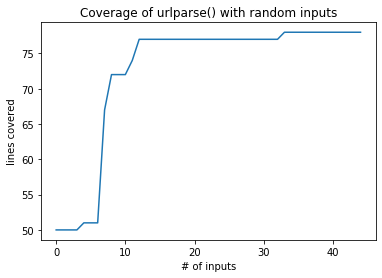

In [54]:
#Lines covered VS # of random inputs
plt.plot(cumulative_coverage)
plt.title('Coverage of urlparse() with random inputs')
plt.xlabel('# of inputs')
plt.ylabel('lines covered');

The nice thing about this strategy is that, applied to larger programs, it will happily explore one path after the other – covering functionality after functionality.  All that is needed is a means to capture the coverage.

## Synopsis

This chapter introduces a `MutationFuzzer` class that takes a list of _seed inputs_ which are then mutated:

In [55]:
seed_input = "http://www.google.com/search?q=fuzzing"
mutation_fuzzer = MutationFuzzer(seed=[seed_input])
[mutation_fuzzer.fuzz() for i in range(10)]

['http://www.google.com/search?q=fuzzing',
 'http://www.gNoogl(e.com/search?q=fezing',
 "htt://www.ole.o'searsh?q=fzzing",
 'htdp://www.google.com/sarcmh?q=fuzzyng',
 'http://www>gXoogle.com/seavch?q=fuzzing',
 'http//www.google.co/seaErch?q=fuzzing',
 'http://www.googleom/3search?=ftzzig',
 'http://www.google.com/sarch?q^=fuzzing',
 'http://www.google.3comsearch?q=fu|zzing',
 'ttp://www.google.comosearch?q=fuzzing`']

The `MutationCoverageFuzzer` maintains a _population_ of inputs, which are then evolved in order to maximize coverage.

In [56]:
mutation_fuzzer = MutationCoverageFuzzer(seed=[seed_input])
mutation_fuzzer.runs(http_runner, trials=10000)
mutation_fuzzer.population[:5]

['http://www.google.com/search?q=fuzzing',
 'http://www.googleT.com/search?q=fuzz6ing',
 'http://www.google.4om/search7qD=fuzz6ing',
 'http://wwKw.google.4Com/search7qD=fuzz6ijg',
 'htTp://ww.goofle.com/seaCh?q=fuzzig']

## Lessons Learned

* Randomly generated inputs are frequently invalid – and thus exercise mostly input processing functionality.
* Mutations from existing valid inputs have much higher chances to be valid, and thus to exercise functionality beyond input processing.


## Next Steps

In the next chapter on [greybox fuzzing](GreyboxFuzzer.ipynb), we further extend the concept of mutation-based testing with _power schedules_ that allow to pends more energy on seeds that exercise "unlikely" paths and seeds that are "closer" to a target location.

### Exercise 1: Fuzzing CGI decode with Mutations

Apply the above _guided_ mutation-based fuzzing technique on `cgi_decode()` from the ["Coverage"](Coverage.ipynb) chapter.  How many trials do you need until you cover all variations of `+`, `%` (valid and invalid), and regular characters?

In [ ]:
from Coverage import cgi_decode

In [ ]:
seed = ["Hello World"]
cgi_runner = FunctionCoverageRunner(cgi_decode)
m = MutationCoverageFuzzer(seed)
results = m.runs(cgi_runner, 10000)

In [ ]:
m.population

In [ ]:
cgi_runner.coverage()

In [ ]:
all_coverage, cumulative_coverage = population_coverage(
    m.population, cgi_decode)

import matplotlib.pyplot as plt
plt.plot(cumulative_coverage)
plt.title('Coverage of cgi_decode() with random inputs')
plt.xlabel('# of inputs')
plt.ylabel('lines covered');

After 10,000 runs, we have managed to synthesize a `+` character and a valid `%xx` form.  We can still do better.

### Exercise 2: Fuzzing bc with Mutations

Apply the above mutation-based fuzzing technique on `bc`, as in the chapter ["Introduction to Fuzzing"](Fuzzer.ipynb).

#### Part 1: Non-Guided Mutations

Start with non-guided mutations.  How many of the inputs are valid?

**Solution.** This is just a matter of tying a `ProgramRunner` to a `MutationFuzzer`:

In [ ]:
from Fuzzer import ProgramRunner

In [ ]:
seed = ["1 + 1"]
bc = ProgramRunner(program="bc")
m = MutationFuzzer(seed)
outcomes = m.runs(bc, trials=100)

In [ ]:
outcomes[:3]

In [ ]:
sum(1 for completed_process, outcome in outcomes if completed_process.stderr == "")

#### Part 2: Guided Mutations

Continue with _guided_ mutations.  To this end, you will have to find a way to extract coverage from a C program such as `bc`.  Proceed in these steps:

First, get [GNU bc](https://www.gnu.org/software/bc/); download, say, `bc-1.07.1.tar.gz` and unpack it:

In [ ]:
!curl -O mirrors.kernel.org/gnu/bc/bc-1.07.1.tar.gz

In [ ]:
!tar xfz bc-1.07.1.tar.gz

Second, configure the package:

In [ ]:
!cd bc-1.07.1; ./configure

Third, compile the package with special flags:

In [ ]:
!cd bc-1.07.1; make CFLAGS="--coverage"

The file `bc/bc` should now be executable...

In [ ]:
!cd bc-1.07.1/bc; echo 2 + 2 | ./bc

...and you should be able to run the `gcov` program to retrieve coverage information.

In [ ]:
!cd bc-1.07.1/bc; gcov main.c

As sketched in the ["Coverage" chapter](Coverage.ipynb), the file [bc-1.07.1/bc/main.c.gcov](bc-1.07.1/bc/main.c.gcov) now holds the coverage information for `bc.c`.  Each line is prefixed with the number of times it was executed. `#####` means zero times; `-` means non-executable line.

Parse the GCOV file for `bc` and create a `coverage` set, as in `FunctionCoverageRunner`.  Make this a `ProgramCoverageRunner` class that would be constructed with a list of source files (`bc.c`, `main.c`, `load.c`) to run `gcov` on.

When you're done, don't forget to clean up:

In [ ]:
!rm -fr bc-1.07.1 bc-1.07.1.tar.gz

### Exercise 3

In this [blog post](https://lcamtuf.blogspot.com/2014/08/binary-fuzzing-strategies-what-works.html), the author of _American Fuzzy Lop_ (AFL), a very popular mutation-based fuzzer discusses the efficiency of various mutation operators.  Implement four of them and evaluate their efficiency as in the examples above.

### Exercise 4

When adding a new element to the list of candidates, AFL does actually not compare the _coverage_, but adds an element if it exercises a new _branch_.  Using branch coverage from the exercises of the ["Coverage"](Coverage.ipynb) chapter, implement this "branch" strategy and compare it against the "coverage" strategy, above.

### Exercise 5

Design and implement a system that will gather a population of URLs from the Web.  Can you achieve a higher coverage with these samples?  What if you use them as initial population for further mutation?